# Testing with generated complex data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from numpy.linalg import norm
from dataset import AdSBHDataset
from model import AdSBHNet
from constants import dreal, dcomplex

Generate a dataset.

coef = 1.0


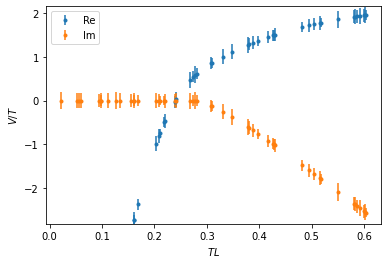

In [2]:
dataset = AdSBHDataset(N=50, threshold=0.0, coef=1.0)
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend()
print(f'coef = {dataset.coef}')

## Consistency check
Learnable parameters set to zero (standard BH).

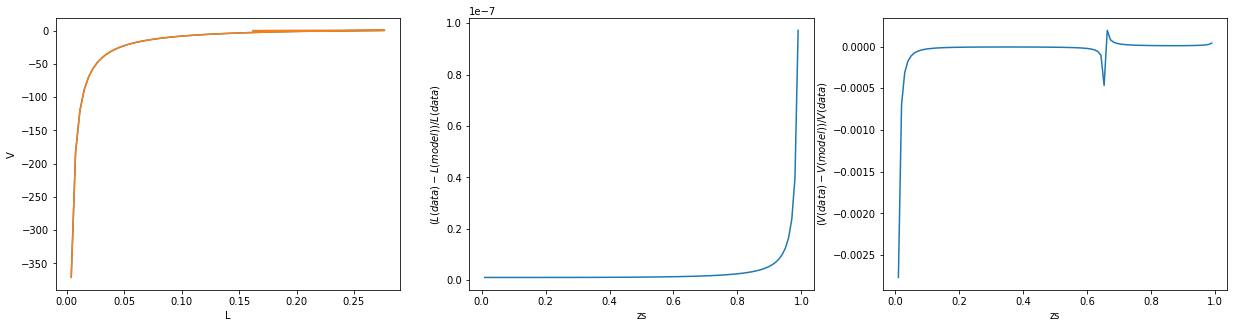

In [3]:
model = AdSBHNet(N=1)
model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
zs = np.linspace(0.01, 0.99, 100)
d_L = np.array([dataset.integrate_L(z).real for z in zs])
d_V = np.array([dataset.integrate_V(z).real for z in zs])
m_L = np.array([model.integrate_L(z).real.item() for z in zs])
m_V = np.array([model.integrate_V(z).real.item() for z in zs])
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].plot(d_L, d_V)
axs[0].plot(m_L, m_V)
axs[0].set_xlabel('L')
axs[0].set_ylabel('V')
axs[1].plot(zs, (d_L-m_L)/d_L)
axs[1].set_xlabel('zs')
axs[1].set_ylabel(r'$(L(data)-L(model))/L(data)$')
axs[2].plot(zs, (d_V-m_V)/d_V)
axs[2].set_xlabel('zs')
axs[2].set_ylabel(r'$(V(data)-V(model))/V(data)$');

Agreement between dataset and model is reasonable with zero parameters. How about with some random parameters?

In [4]:
zsTest = [complex(0.5140773201571425,0.6088586260994207), complex(0.24682691472024243,0.25717264917958227), complex(0.9423246752839594,0.5756077477788868), complex(0.2763091146626422,0.8322138131326102), complex(0.8135210310905163,0.827883184115852), complex(0.8770065579111783,0.18831450668118732), complex(0.5362459452105253,0.26695691078691164), complex(0.8290262857616526,0.7065548068714746), complex(0.235666573278702,0.6918584708386342), complex(0.964962903714488,0.1039712498056573)]
model = AdSBHNet(N=2)
model.a = nn.Parameter(torch.tensor([-0.38583488391471865, -0.022772730385574654], dtype=dreal))
model.b = nn.Parameter(torch.tensor([0.1051477498734641, -0.47990861356992914], dtype=dreal))
model.logcoef = nn.Parameter(torch.tensor(1.0, dtype=dreal).log())
for zs in zsTest:
    print(f'{zs:.6f}\t{model.integrate_L(zs):.6f}\t{model.integrate_dL(zs):.6f}\t{model.integrate_V(zs):.6f}')

0.514077+0.608859j	0.246214+0.232299j	0.505140-0.191490j	4.794442+1.008259j
0.246827+0.257173j	0.093698+0.096051j	0.393678-0.015213j	0.202695+7.423206j
0.942325+0.575608j	0.435174+0.098654j	0.431034-0.377000j	2.203525-1.745102j
0.276309+0.832214j	0.155089+0.431744j	0.846104-0.457660j	9.412677+0.625518j
0.813521+0.827883j	0.458717+0.271368j	0.579214-0.314565j	4.331217-2.660792j
0.877007+0.188315j	0.278151-0.004315j	0.167934-0.334539j	0.784873-0.253729j
0.536246+0.266957j	0.204066+0.082518j	0.349669-0.111257j	1.068843+1.799413j
0.829026+0.706555j	0.428050+0.200385j	0.510050-0.327255j	3.520766-1.920220j
0.235667+0.691858j	0.089366+0.322717j	0.771364-0.045648j	8.494551+3.255786j
0.964963+0.103971j	0.249756-0.051467j	0.030739-0.619639j	0.385759-0.339094j


Let's check that $a=b=0$ is a local minimum of the loss function

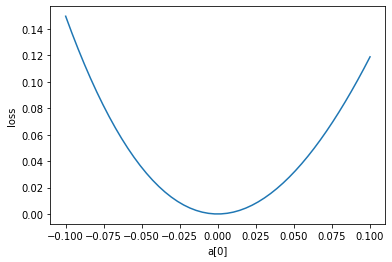

In [4]:
A = np.linspace(-0.1, 0.1, 50)
losses = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    losses.append(loss.item())
plt.plot(A, losses)
plt.xlabel('a[0]')
plt.ylabel('loss');

Check that gradients agree with finite difference derivatives.

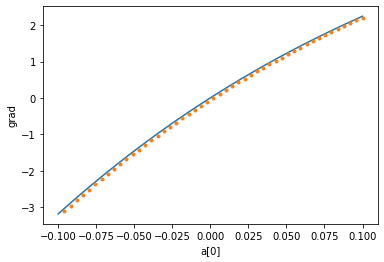

In [5]:
grads = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    model.zero_grad()
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    loss.backward()
    grads.append(model.a.grad[0].item())
plt.plot(A, grads)
plt.plot(A[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(A[1]-A[0]), '.')
plt.xlabel('a[0]')
plt.ylabel('grad');

Do the same check w.r.t. $b$.

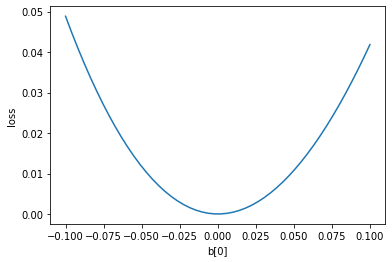

In [6]:
B = np.linspace(-0.1, 0.1, 50)
losses = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    losses.append(loss.item())
plt.plot(B, losses)
plt.xlabel('b[0]')
plt.ylabel('loss');

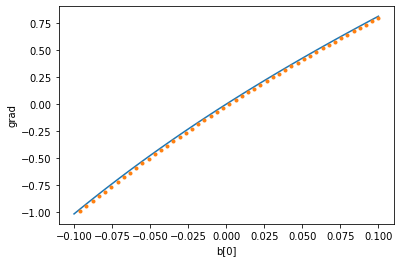

In [7]:
grads = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    model.zero_grad()
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    loss.backward()
    grads.append(model.b.grad[0].item())
plt.plot(B, grads)
plt.plot(B[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(B[1]-B[0]), '.')
plt.xlabel('b[0]')
plt.ylabel('grad');

## Training

In [5]:
def loss_f(V_diff, sigma):
    V = V_diff[torch.isfinite(V_diff)]
    s = sigma[torch.isfinite(V_diff)]
    return torch.mean((V/s).abs()**2)

In [6]:
def train(opt, epochs, lr=0.01, diff_cutoff=1e-6):
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=len(dataset))
    if opt == 'lbfgs':
        optimizer = torch.optim.LBFGS(model.parameters())
    elif opt == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif opt == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        print(f'Unknown optimizer {opt}, defaulting to Adam.')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    try:
        for epoch in range(epochs):
            for L, V, sigma in loader:
                def closure():
                    optimizer.zero_grad()
                    V_pred = model(L)
                    V_diff = V_pred + model.shift - V
                    loss = loss_f(V_diff, sigma)
                    loss.backward()
                    losses.append(loss.item())
                    return loss
                optimizer.step(closure)
                a_vals.append(model.a.detach().numpy().copy())
                b_vals.append(model.b.detach().numpy().copy())
                coef_vals.append(model.logcoef.exp().item())
                shift_vals.append(model.shift.item())
                diff = np.sqrt(norm(a_vals[-1] - a_vals[-2])**2
                                    + norm(b_vals[-1] - b_vals[-2])**2
                                    + np.abs(coef_vals[-1] - coef_vals[-2])**2
                                    + np.abs(shift_vals[-1] - shift_vals[-1])**2)
            if epochs < 50 or epoch % (epochs // 50) == 0:
                print(f'epoch={epoch:2d}, loss={losses[-1]:0.6f}, diff={diff:.6f}')
            if diff < diff_cutoff:
                print(f'Step length less than {diff_cutoff}. Stopping.')
                break
    except KeyboardInterrupt:
        print('Stopping.')
    plt.plot(losses)
    plt.xlabel('step')
    plt.ylabel('loss');

In [36]:
model = AdSBHNet(N=1, std=0.3)

In [37]:
a_vals, b_vals, coef_vals, shift_vals = [model.a.detach().numpy().copy()], [model.b.detach().numpy().copy()], [model.logcoef.exp().item()], [model.shift.item()]
losses = []

fzInit = model.eval_f(z).detach().numpy().real
gzInit = model.eval_g(z).detach().numpy().real
fz0 = 1-z**4
gz0 = 1/fz0

epoch= 0, loss=27.459139, diff=0.034758
epoch=10, loss=0.597008, diff=0.017766
epoch=20, loss=1.959263, diff=0.004996
epoch=30, loss=0.038901, diff=0.006048
epoch=40, loss=0.245579, diff=0.002967
epoch=50, loss=0.027802, diff=0.002229
epoch=60, loss=0.027354, diff=0.001583
epoch=70, loss=0.016359, diff=0.000440
epoch=80, loss=0.004945, diff=0.000805
Stopping.


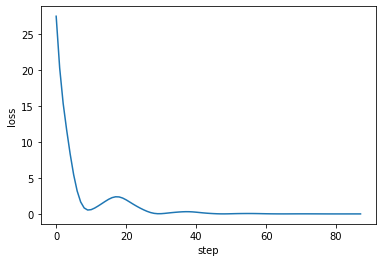

In [38]:
train('adam', 500, 0.02)

# Results

The predicted potential in terms of separation.

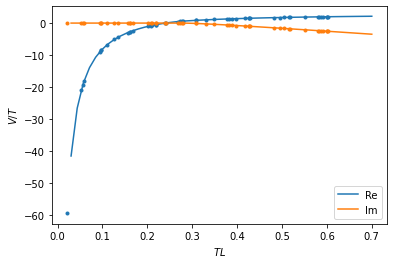

In [39]:
with torch.no_grad():
    L_grid = torch.linspace(0.03, 0.7, 50)
    V_grid = model(L_grid)
plt.plot(L_grid, V_grid.real, label='Re')
plt.plot(L_grid, V_grid.imag, label='Im')
plt.errorbar(dataset.L, dataset.V.real, yerr=dataset.sigma.real, fmt='.', c='C0')
plt.errorbar(dataset.L, dataset.V.imag, yerr=dataset.sigma.imag, fmt='.', c='C1')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.legend();

The complex curve of real $L$.

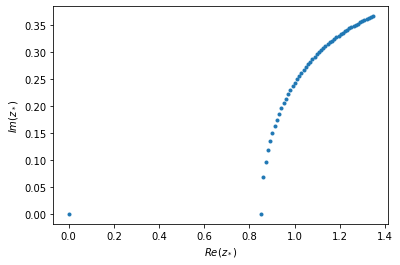

In [40]:
plt.plot([np.real(x) for x in model.curve_zs], [np.imag(x) for x in model.curve_zs], '.')
plt.xlabel(f'$Re(z_*)$')
plt.ylabel(f'$Im(z_*)$');

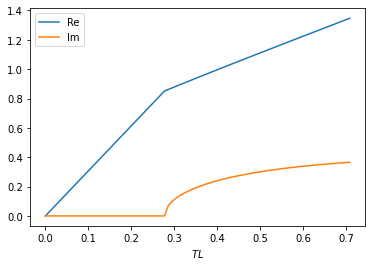

In [41]:
plt.plot(model.curve_L, [np.real(x) for x in model.curve_zs], label='Re')
plt.plot(model.curve_L, [np.imag(x) for x in model.curve_zs], label='Im')
plt.xlabel(f'$T L$')
plt.legend();

Parameter evolution.

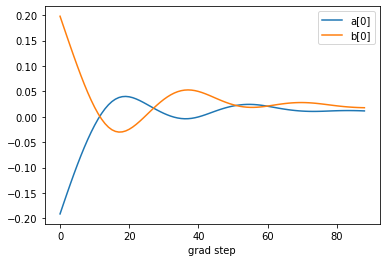

In [42]:
for i in range(len(a_vals[0])):
    plt.plot([a[i] for a in a_vals], label=f'a[{i}]')
for i in range(len(a_vals[0])):
    plt.plot([b[i] for b in b_vals], label=f'b[{i}]')
plt.xlabel('grad step')
plt.legend();

Plot the metric functions. This should converge to BH functions.

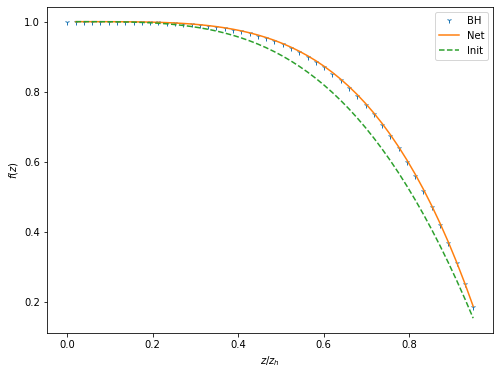

In [43]:
z = torch.linspace(0, 0.95, 50)
fz = model.eval_f(z).detach().numpy().real
gz = model.eval_g(z).detach().numpy().real
plt.subplots(figsize=(8, 6))
plt.plot(z, fz0, '1', label='BH')
plt.plot(z, fz, label='Net')
plt.plot(z, fzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$f(z)$')
plt.legend();

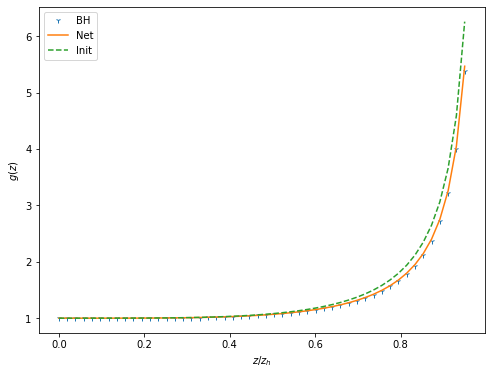

In [44]:
plt.subplots(figsize=(8, 6))
plt.plot(z, gz0, '1', label='BH')
plt.plot(z, gz, label='Net')
plt.plot(z, gzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$g(z)$')
plt.legend();